# CTA data analysis with Gammapy

## Caveat

* This notebook was prepared in a hurry, it is incomplete.
* The CTA first data challenge (1DC) data is still in preparation.
* Accessing background models doesn't work yet with Gammapy
* Several other small known issues with the data and Gammapy.
* Work in progress ... please excuse the mess!

## Introduction

The focus of this notebook is on demonstrating how to quickly perform a standard analysis of a given target in the sky. The gammapy functions and classes that we'll use won't be explained in detail. Please refer to the other gammapy tutorial notebooks, if you're interested.

At some point there should be a convenience class to make this kind of analysis easier, feedback on how this should be implemented is welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("/Users/facero/Documents/Work/Program/gammapy/gammapy")


In [2]:
# Check package versions, if something goes wrong here you won't be able to run the notebook
import gammapy
import numpy as np
import astropy
import regions
import sherpa
import uncertainties
import photutils

print('gammapy:', gammapy.__version__)
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('regions:', regions.__version__)
print('sherpa:', sherpa.__version__)
print('uncertainties:', uncertainties.__version__)
print('photutils:', photutils.__version__)

gammapy: 0.7.dev5108
numpy: 1.12.1
astropy: 1.3.2
regions: 0.2
sherpa: 4.9.1
uncertainties: 3.0.1
photutils: 0.3.2


In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from regions import CircleSkyRegion
from photutils.detection import find_peaks
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator, ReflectedRegionsBackgroundEstimator
from gammapy.utils.energy import EnergyBounds
from gammapy.detect import TSImageEstimator

In [5]:
# Setup the logger
import logging
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)

## Load Data

First, we have to load the CTA data exported to fits format (the format is described in detail [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/)).

In [6]:
DATA_DIR = '$CTADATA/index/gps'

ds = DataStore.from_dir(DATA_DIR)
ds.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /Users/facero/Documents/Work/CTA/meetings/gammapy-meudon-tutorial/handson/index/gps
Rows: 738
OBS_ID: 110000 -- 110122
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Number of observations: 123


In [8]:
print(ds.obs_table.colnames)
obs_colnames = ['OBS_ID', 'DATE_OBS', 'TIME_OBS', 'GLON_PNT', 'GLAT_PNT','EVENTS_FILENAME']
ds.obs_table[:100][obs_colnames]

['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE_OBS', 'TIME_OBS', 'DATE_END', 'TIME_END', 'N_TELS', 'OBJECT', 'CALDB', 'IRF', 'EVENTS_FILENAME', 'EVENT_COUNT']


OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT,EVENTS_FILENAME
int64,str10,str8,float64,float64,str32
110042,2021-01-03,14:06:51,242.249987017,4.28067454836e-05,handson/data/gps/obs_110042.fits
110047,2021-01-03,16:46:51,249.750006355,-9.55234203475e-06,handson/data/gps/obs_110047.fits
110041,2021-01-03,13:34:51,240.749976805,-3.35245020777e-05,handson/data/gps/obs_110041.fits
110011,2021-01-01,17:50:51,256.499994576,-1.29996977948,handson/data/gps/obs_110011.fits
110040,2021-01-03,13:02:51,300.000015838,-1.29999832338,handson/data/gps/obs_110040.fits
110016,2021-01-01,20:30:51,263.99999857,-1.29998055229,handson/data/gps/obs_110016.fits
110035,2021-01-02,20:30:51,292.500000914,-1.29998450366,handson/data/gps/obs_110035.fits
110015,2021-01-01,19:58:51,262.500039022,-1.30002779719,handson/data/gps/obs_110015.fits
110023,2021-01-02,14:06:51,274.500017798,-1.30000905318,handson/data/gps/obs_110023.fits


In [143]:
ras = ds.obs_table['RA_PNT'] * u.deg
decs = ds.obs_table['DEC_PNT'] * u.deg
 
target_position = SkyCoord(270, -1, unit='deg', frame='galactic')
pointings = SkyCoord(ras, decs, frame='icrs' )
dists = pointings.separation(target_position)
obs_id = ds.obs_table['OBS_ID'][(dists < 8.5 * u.deg)]
print(len(obs_id), "observations within radius")

obs_list = ds.obs_list(obs_id)


34 observations within radius


## Define inputs



In [151]:
# Large exclusion region centered on Vela Jr
on_radius = 1 * u.deg
on_region = CircleSkyRegion(center=SkyCoord(266.26, -02.22, unit='deg', frame='galactic'), radius=on_radius)




In [152]:
# Define reference image centered on the target
xref = target_position.galactic.l.value
yref = target_position.galactic.b.value
xsize = 10 * u.deg
ysize = 5 * u.deg

binsz = 0.025 # degree per pixel
xnpix = int((xsize / binsz).value)
ynpix = int((ysize / binsz).value)

ref_image = SkyImage.empty(
    nxpix=xnpix, nypix=ynpix, binsz=binsz,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL',
)
print(ref_image)

Name: None
Data shape: (200, 400)
Data type: float64
Data unit: 
Data mean: 0.000e+00
WCS type: ['GLON-TAN', 'GLAT-TAN']



(<matplotlib.figure.Figure at 0x12d9b98d0>,
 <matplotlib.colorbar.Colorbar at 0x12c8a2048>)

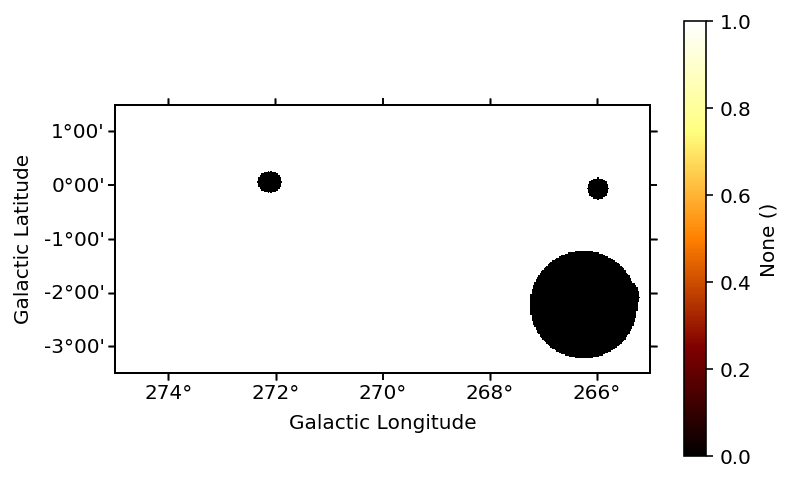

In [168]:

exclusion_mask = ref_image.region_mask(on_region)

#Read table of detected sources obtained later on
#Make each region a mask and sum them.
src=Table.read('detected_sources.fits')

off_regions=[]

for s in src:
    
    circle=CircleSkyRegion(center=SkyCoord(s['icrs_ra_peak'], s['icrs_dec_peak'], unit='deg', frame='fk5'), radius=0.2 *u.deg)

    mask = ref_image.region_mask(circle)
    exclusion_mask.data += mask.data

exclusion_mask.data = np.invert(exclusion_mask.data)

exclusion_mask.plot(add_cbar=True)

## Make maps

Standard analysis products: Counts and Significance images

In [154]:
bkg_estimator = RingBackgroundEstimator(
    r_in=1.2 * u.deg,
    width=0.2 * u.deg,
)
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=0.2 * u.TeV,
    emax=100 * u.TeV,
    offset_max=6 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=exclusion_mask,
)
images = image_estimator.run(obs_list)
images.names

/Users/facero/Documents/Work/Program/gammapy/gammapy/gammapy/cube/core.py:85: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/Users/facero/Documents/Work/Program/gammapy/gammapy/gammapy/cube/core.py:85: RuntimeWarning: invalid value encountered in log
  log_data = np.log(self.data.value)
/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2444: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


['counts', 'exposure', 'background', 'excess', 'flux', 'psf']

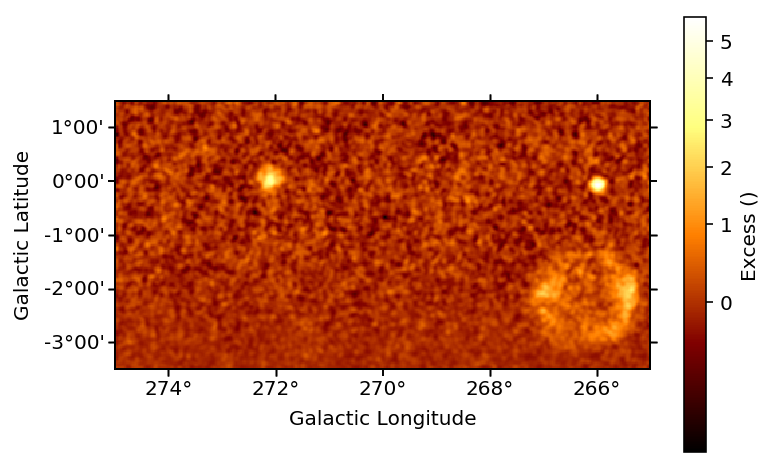

In [155]:
images['excess'].smooth(radius=3).plot(stretch='sqrt',add_cbar=True)
plt.show()

(<matplotlib.figure.Figure at 0x12f804278>,
 None)

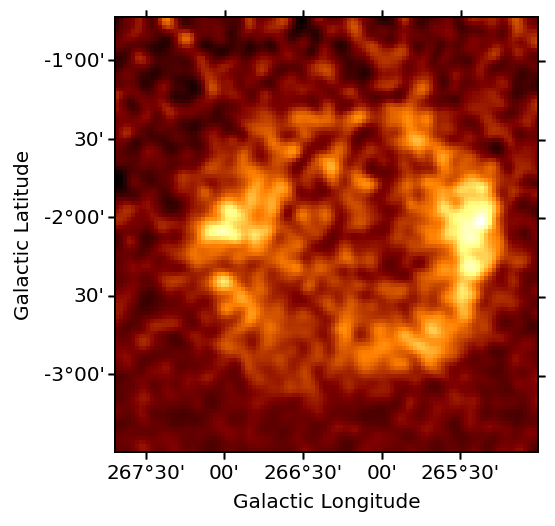

In [156]:
images['excess'].cutout(
        position=SkyCoord(266.2,-2.2, unit='deg', frame='galactic'),
        size=(3*u.deg, 3*u.deg)).smooth(radius=3).plot()

counts


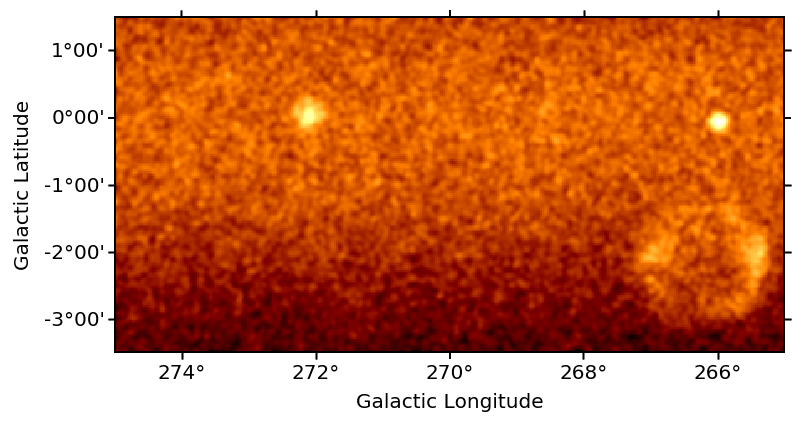

exposure


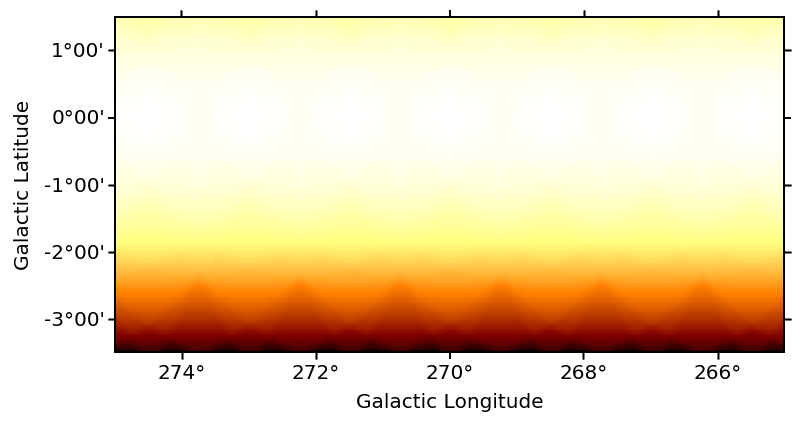

background


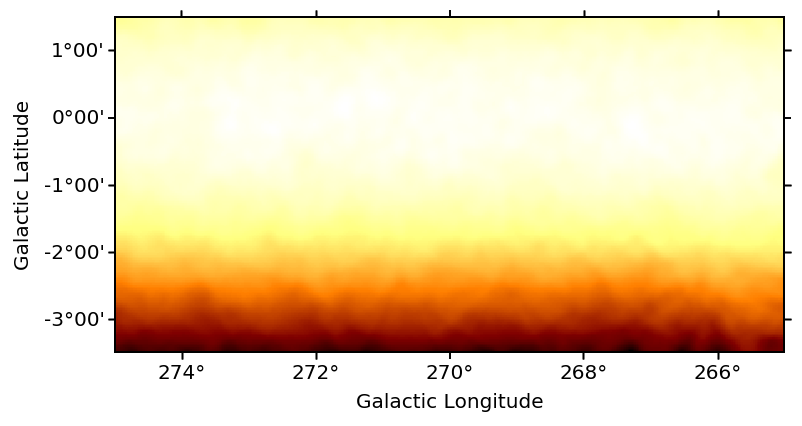

excess


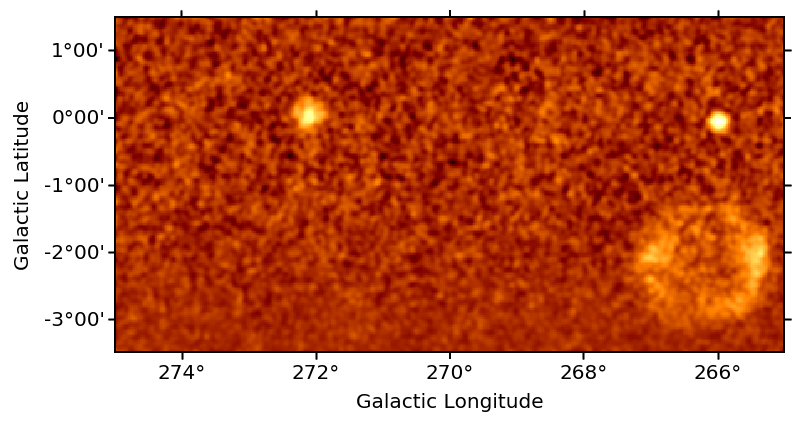

flux


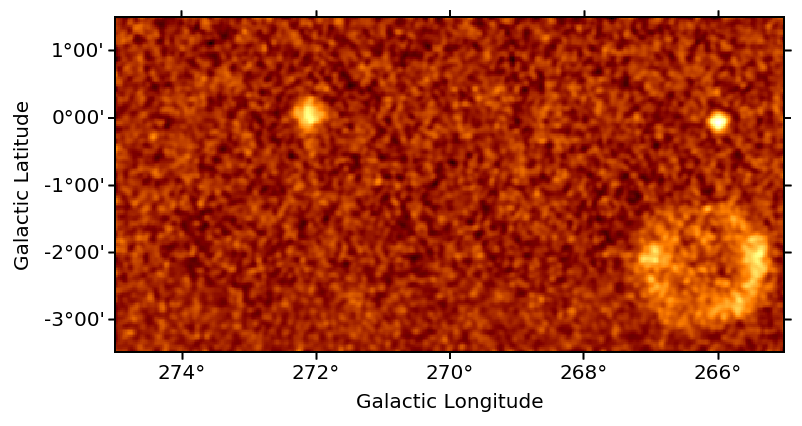

psf


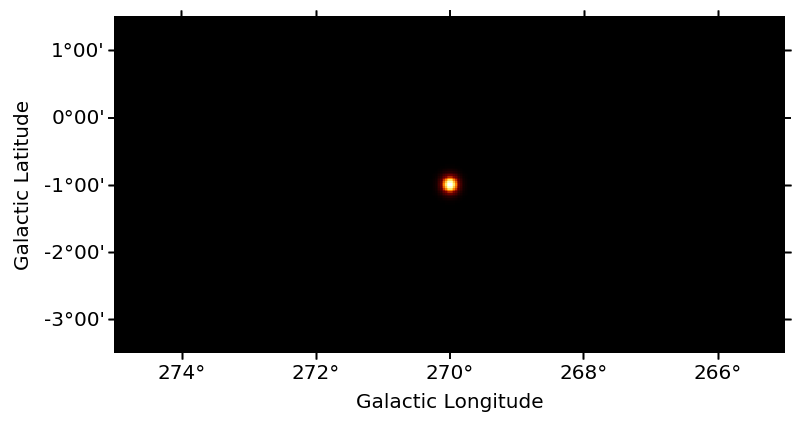

In [157]:
for i,im in enumerate(images):
    print(images.names[i])
    im.smooth(radius=3).plot(stretch='sqrt') ; plt.show()

## Source Detection

Use [photutils.find_peaks](http://photutils.readthedocs.io/en/stable/api/photutils.find_peaks.html) to detect point-like sources on the images:

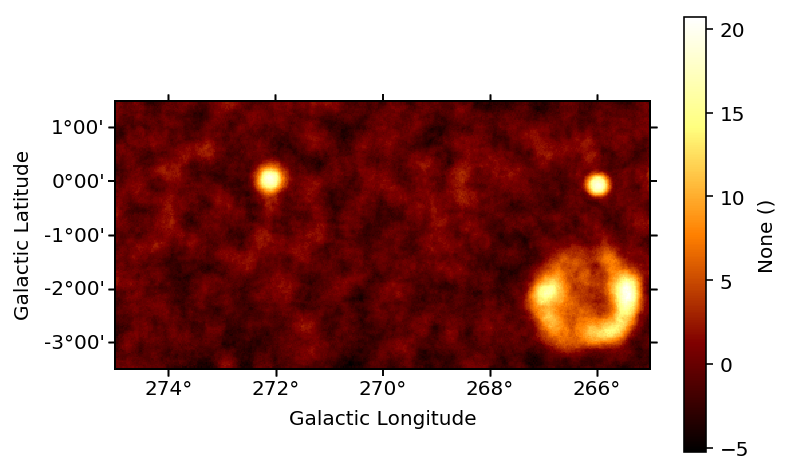

x_peak,y_peak,icrs_ra_peak,icrs_dec_peak,peak_value
,,deg,deg,
int64,int64,float64,float64,float64
380,46,131.051667813,-46.437106916,17.1132188249
382,53,131.205627747,-46.2900864355,20.6857455643
380,55,131.306699205,-46.2981874095,19.4995207885
321,56,132.680504254,-47.4269727342,16.997498177
383,56,131.268180743,-46.2242294529,20.4252467665
381,57,131.340920902,-46.2477500363,20.1820787185
318,58,132.807627707,-47.4531221104,15.0093361349
380,60,131.447841056,-46.2207563785,20.0037083086


In [166]:
# Significance image
# Just for fun, let's compute it by hand ...
from astropy.convolution import Tophat2DKernel
kernel = Tophat2DKernel(0.2 *u.deg / (binsz *u.deg))
kernel.normalize('peak')

counts_conv = images['counts'].convolve(kernel.array)
background_conv = images['background'].convolve(kernel.array)

from gammapy.stats import significance
significance_image = SkyImage.empty_like(ref_image)
significance_image.data = significance(counts_conv.data, background_conv.data)

significance_image.plot( add_cbar=True)
plt.show()

sources = find_peaks(data=significance_image.data, threshold=15, wcs=significance_image.wcs)

sources.write('detected_sources.fits',overwrite=True)

sources